# Fine-tuning LayoutLM using the SROIE dataset
This notebook is my attempt at fine-tuning the LayoutLM model using the SROIE dataset for information extraction. The model is presented in the paper "[LayoutLM: Pre-training of Text and Layout for Document Image Understanding](https://arxiv.org/abs/1912.13318)" by Yiheng Xu, Minghao Li, Lei Cui, Shaohan Huang, Furu Wei and Ming Zhou and the notebook has been greatly inspired by Github user's"ruifcruz" notebook titled "Fine tune SROIE on LayoutLM".
- LayoutLM Github repo [here](https://github.com/microsoft/unilm/tree/master/layoutlm).
- The dataset was taken from the ICDAR 2019 SROIE competition [here](https://rrc.cvc.uab.es/?ch=13).
- "Fine tune SROIE on LayoutLM" by ruifcruz [here](https://github.com/ruifcruz/sroie-on-layoutlm).

## Notes:
- The notebook is using a preprocessing script included in the model's repo [here](https://github.com/microsoft/unilm/tree/master/layoutlm/examples/seq_labeling) which was originally used to fine tune the FUNSD dataset. We can train on the SROIE dataset with the same script because it's meant for sequence labeling.
- The original authors of the model got an F1 score **0.946** (using the base model) and the maximum I got was an F1 score **0.966** (10 epochs). This is an improvement over ruifcruz's score, because I also included the label "company address". It's also an improvement over the authors score and the reason for that, as explained by ruifcruz, could be:
  - Different hyperparameters,
  - quality OCR - the authors didn't use SROIE OCR scans, but created their own,
  - better preprocessing

# 1. Pre-processing the dataset
Before fine-tuning the model, we have to preprocess the SROIE dataset which can be downloaded from [here](https://drive.google.com/drive/folders/1ShItNWXyiY1tFDM5W02bceHuJjyeeJl2). The dataset contains multiple subfolders, because the competition is split up into three tasks **Text Localization, Optical character recognition (OCR)** and **Information Extraction (IE)** and some folders are meant for their specific task. For our purposes we're only interested in the last task, so we'll be using these two folders: 
- **0325updated.task1train(626p)** - contains receipt images (.jpg) and corresponding OCR'd bounding boxes and text (.txt)
- **0325updated.task2train(626p)** - contains labeled text (.txt) in a JSON format.

In [1]:
!which python

/home/phunc20/.virtualenvs/layoutlm/bin/python


In [2]:
import os
import glob
import json 
import random
from pathlib import Path
from difflib import SequenceMatcher


import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

## Preparing the dataset
The location of the SROIE dataset and the name of an example file used for demonstration purposes

In [3]:
sroie_folder_path = Path("sroie-datasetv2")
example_file = Path("X51005365187.txt")

Originally, the next few cells were written in order to create new directory structures like the one on Kaggle using the original SROIE link, but at long last I found it too hard (e.g. I did not know which files goes into `test/`). So I have opted the easier alternative: Downloaded [the accompanying dataset](https://blahblahblah.com) of this notebook from Kaggle.

### Reading the words and bounding boxes
So, the first step is reading the OCR data, where every line in the file includes a group of words and a bounding box which defines them. All we have to do is read the file, discard the unneeded points in the bounding box (because the model requires only the top-left and bottom-right points) and save it in Pandas Dataframe.

In [4]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue
        
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'], dtype=np.int16)
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe


# Example usage
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("== File content ==")
!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==")
bbox.head(5)

== File content ==
17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,

== Dataframe ==


/home/phunc20/.virtualenvs/layoutlm/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised


,filename,x0,y0,x2,y2,line
0,X51005365187,17,35,371,91,3-1707067
1,X51005365187,222,115,511,143,F&P PHARMACY
2,X51005365187,274,148,457,174,(002309592-P)
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,"
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,"


In [5]:
bbox.dtypes

filename    object
x0           int16
y0           int16
x2           int16
y2           int16
line        object
dtype: object

Note that the author of this notebook chose `int16` to contain the coordinates, which is quite reasonable:

- $2^{15} \approx 1000 \cdot 32$, usually no image size will exceed this
- $2^{7} = 128$ is way too small to include all image sizes

### Reading the entities file
Now we need to read the entities file to know what to label in our text.

In [6]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


# Example usage
entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}

== Dataframe ==


,company,date,address,total
0,F&P PHARMACY,02/03/2018,"NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...",31.90


### Assigning labels to words using the entities data
We have our words/lines and entities, now we just need to put them together by labeling our lines using the entities values. We'll be doing that by substring matching the entities values with the lines and if they don't match to a similarity check using pythons _difflib.SequenceMatcher_ and assigning anything above the 0.8 (80%) prediction match.

The **label "O"** will define all our words not labeled during the assignment step, because it's required for us to label everything.

In [7]:
# Assign a label to the line by checking the similarity
# of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
        
        
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
            
            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
               (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
               matches_count == len(entity_set):
                return column.upper()

    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: F&P PHARMACY
Assigned label: COMPANY


With a function which can handle the labeling of our lines, we'll create another function to label all our line in one DataFrame (so one receipt).

As simple as this could be, the problem arises when we get lines which would all pass the same match, like **TOTAL** for example; a receipt could have only one item on it and its price could be the same as the final total, so duplicate labels. Or maybe part of the address is also present at the end of the receipt.

To ignore such examples, I wrote simple hard-coded rules to assign *total* and *date* to only the largest bounding boxes it could find (based on its area) and to not allow the address to be assigned after date or total.

In [8]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(25)

,filename,x0,y0,x2,y2,line,label
0,X51005365187,17,35,371,91,3-1707067,O
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY
2,X51005365187,274,148,457,174,(002309592-P),O
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,",ADDRESS
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,",ADDRESS
5,X51005365187,111,250,623,275,"SEKSYEN 10, 43300 SERI KEMBANGAN,",ADDRESS
6,X51005365187,186,284,538,308,SELANGOR DARUL EHSAN,ADDRESS
7,X51005365187,251,316,484,339,TEL 03-89599823,O
8,X51005365187,182,351,346,378,GST REG NO,O
9,X51005365187,274,387,461,409,TAX INVOICE,O


### Split words
For the last part we're splitting the lines into separate tokens with their own bounding boxes.

Splitting the bounding boxes based on word length is probably not the best approach, but it's good enough.

In [9]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0', 'x2', 'line'] = [x0, x2, word]
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005365187,222,115,294,143,F&P,COMPANY
1,X51005365187,299,115,491,143,PHARMACY,COMPANY


### Putting it all together
We defined all our functions, now we just have to use them on every file and transform the dataset into a format which the script/model can parse.

In [10]:
from time import perf_counter

def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  ignore = []

  entities_files = [file for file in entities_folder.glob("*.txt") if file.name not in [f + '.txt' for f in ignore] and not '(' in file.name]
  bbox_files = [file for file in bbox_folder.glob("*.txt") if file.name not in [f + '.txt' for f in ignore] and not '(' in file.name]
  img_files = [file for file in img_folder.glob("*.jpg") if file.name not in [f + '.jpg' for f in ignore] and not '(' in file.name]

 # entities_files = [file for file in entities_folder.glob("*.txt") if '(' not in file.name]
 # bbox_files = [file for file in bbox_folder.glob("*.txt") if '(' not in file.name]
  #img_files = [file for file in img_folder.glob("*.jpg") if '(' not in file.name]

  entities_files.sort()
  bbox_files.sort()
  img_files.sort()
    
  data = []

  print("Reading dataset:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    # Read the files

    try:
        bbox = read_bbox_and_words(bbox_file)
        entities = read_entities(entities_file)
        image = Image.open(img_file)
    except: 
        print(bbox_file)
        raise



    # Assign labels to lines in bbox using entities
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    # Split lines into separate tokens
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns, dtype=np.int16)
    del bbox_labeled


    # Do another label assignment to keep the labeling more precise 
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

Because the dataset has two folders, one meant for training the model and one for testing its performance, we can use the same script to read them both and save them in their respected variables.

In [11]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


  0%|          | 0/626 [00:00<?, ?it/s]

/home/phunc20/.virtualenvs/layoutlm/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
/home/phunc20/.virtualenvs/layoutlm/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.


Reading dataset:


  0%|          | 0/347 [00:00<?, ?it/s]

/home/phunc20/.virtualenvs/layoutlm/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  


## Writting the tranformed dataset
Now that we transformed our dataset into a format the model can understand for its training, we need save everything into files.

### Defining the writing function
We'll use the same function to write into the train and test files

The normalization function is meant to normalize the bounding boxes points in a range [0,1000] using the width and height of the image of the receipt [\[source\]](https://huggingface.co/transformers/model_doc/layoutlm.html#overview).

In [12]:
def normalize(points: list, width: int, height: int) -> list:
  x0, y0, x2, y2 = [int(p) for p in points]
  
  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
  print(f"Writing {name}ing dataset:")
  with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
       open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
       open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

      # Go through each dataset
      for datas in tqdm(dataset, total=len(dataset)):
        data, width, height = datas
        
        filename = data.iloc[0, data.columns.get_loc('filename')]

        # Go through every row in dataset
        for index, row in data.iterrows():
          bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
          normalized_bbox = normalize(bbox, width, height)

          file.write("{}\t{}\n".format(row['line'], row['label']))
          file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
          file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

        # Write a second newline to separate dataset from others
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [13]:
dataset_directory = Path('./', 'dataset')
dataset_directory

PosixPath('dataset')

In [14]:
dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Creating the 'labels.txt' file to the the model what categories to predict.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
  for tag in IOB_tags:
    for label in labels:
      f.write(f"{tag}-{label}\n")
  f.write("O")

Writing training dataset:


  0%|          | 0/626 [00:00<?, ?it/s]

Writing testing dataset:


  0%|          | 0/347 [00:00<?, ?it/s]

**(?)** Why `IOB_tags` only `"S"`? Because no key-value (i.e. question-answer) pairs?<br>
**(R)** I think the variable should be better renamed `BIOES` tag. As for why only `"S"`, I don't really know.

# 2. Fine tune LayoutLM
Since we have finished downloading and transforming our dataset into  training and test sets, now we can start fine-tuning the model.

## Download the model
First we're going to clone the LayoutLM Github project which contains the script to fine tune our model.

I have adapted this cell above to my own laptop environment as follows.

In [17]:
!unilm="$HOME/git-repos/github/microsoft/unilm" && \
     [ ! -d "$unilm" ] && \
    mkdir -p "$unilm" && \
    git clone https://github.com/microsoft/unilm.git "$unilm" || \
    echo "$unilm already exists"

Cloning into '/home/phunc20/git-repos/github/microsoft/unilm'...
remote: Enumerating objects: 3400, done.
remote: Counting objects: 100% (2551/2551), done.
remote: Compressing objects: 100% (2011/2011), done.
remote: Total 3400 (delta 1107), reused 1653 (delta 457), pack-reused 849
Receiving objects: 100% (3400/3400), 6.09 MiB | 1.74 MiB/s, done.
Resolving deltas: 100% (1578/1578), done.


In [18]:
# Incorrect: || in front of && does not work.
!unilm="$HOME/git-repos/github/microsoft/unilm" && \
    pip list | grep layoutlm || echo "Installing layoutlm..." && \
    echo "layoutlm already installed"

You should consider upgrading via the '/home/phunc20/.virtualenvs/layoutlm/bin/python -m pip install --upgrade pip' command.
Installing layoutlm...
layoutlm already installed


In [19]:
!unilm="$HOME/git-repos/github/microsoft/unilm" && \
    pip list | grep layoutlm  && echo "layoutlm already installed" || \
    echo "Installing layoutlm..."

You should consider upgrading via the '/home/phunc20/.virtualenvs/layoutlm/bin/python -m pip install --upgrade pip' command.
Installing layoutlm...


Before installing `layoutlm`, make sure you have `torch` installed in your virtual env. The following is the first few lines from the `setup.py` file in `$unilm/layoutlm/deprecated/`

```python
import torch
from setuptools import find_packages, setup

torch_ver = [int(x) for x in torch.__version__.split(".")[:2]]
assert torch_ver >= [1, 4], "Requires PyTorch >= 1.4"
```

In [21]:
!unilm="$HOME/git-repos/github/microsoft/unilm" && \
    pip list | grep layoutlm  && \
    echo "layoutlm already installed" || \
    echo "Installing layoutlm..." && \
    pip install -e "$unilm/layoutlm/deprecated/"

You should consider upgrading via the '/home/phunc20/.virtualenvs/layoutlm/bin/python -m pip install --upgrade pip' command.
Installing layoutlm...
Obtaining file:///home/phunc20/git-repos/github/microsoft/unilm/layoutlm/deprecated
  Using cached transformers-2.9.0-py3-none-any.whl (635 kB)
  Using cached tensorboardX-2.0-py2.py3-none-any.whl (195 kB)
  Using cached lxml-4.5.1-cp37-cp37m-manylinux1_x86_64.whl (5.5 MB)
  Using cached seqeval-0.0.12-py3-none-any.whl
  Using cached Pillow-8.3.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
     |████████████████████████████████| 1.3 MB 571 kB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 811 kB/s eta 0:00:01
  Using cached tokenizers-0.7.0-cp37-cp37m-manylinux1_x86_64.whl (5.6 MB)
  Using cached sentencepiece-0.1.96-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
     |████████████████████████████████| 749 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 1.5 MB/s

## Training

In [15]:
Path.cwd()

PosixPath('/home/phunc20/downloads/watchlist/sroie/kaggle')

In [16]:
old_dir = Path.cwd()
pretrained_model_folder_input = old_dir / 'sroie-datasetv2/layoutlm-base-uncased/' # Define it so we can copy it into our working directory
pretrained_model_folder = old_dir / 'layoutlm-base-uncased/'
print(pretrained_model_folder_input)
print(pretrained_model_folder)

/home/phunc20/downloads/watchlist/sroie/kaggle/sroie-datasetv2/layoutlm-base-uncased
/home/phunc20/downloads/watchlist/sroie/kaggle/layoutlm-base-uncased


In [17]:
label_file = old_dir / dataset_directory / "labels.txt"
label_file

PosixPath('/home/phunc20/downloads/watchlist/sroie/kaggle/dataset/labels.txt')

In [18]:
!ls

dataset					    README.md
layoutlm-base-uncased			    sroie-datasetv2
layoutlm-using-the-sroie-dataset.ipynb	    trash.py
layoutlm-using-the-sroie-dataset_L01.ipynb


In [19]:
!pwd

/home/phunc20/downloads/watchlist/sroie/kaggle


In [20]:
# Move to the script directory
unilm = Path.home() / "git-repos/github/microsoft/unilm/layoutlm/deprecated/"
os.chdir(unilm / "examples/seq_labeling")

In [21]:
!pwd

/home/phunc20/git-repos/github/microsoft/unilm/layoutlm/deprecated/examples/seq_labeling


First, I'm going to copy the pretrained base model into our working directory to change its configuration file. I'm just changing the number of attention heads from **16** to **12**, because that's the original size.

In [22]:
print(pretrained_model_folder_input)
print(pretrained_model_folder)

/home/phunc20/downloads/watchlist/sroie/kaggle/sroie-datasetv2/layoutlm-base-uncased
/home/phunc20/downloads/watchlist/sroie/kaggle/layoutlm-base-uncased


In [38]:
! cp -r "{pretrained_model_folder_input}" "{pretrained_model_folder}"
! sed -i 's/"num_attention_heads": 16,/"num_attention_heads": 12,/' "{pretrained_model_folder}/"config.json

In [23]:
!grep "num_attention_heads" {pretrained_model_folder_input}/config.json
!grep "num_attention_heads" {pretrained_model_folder}/config.json

  "num_attention_heads": 16,
  "num_attention_heads": 12,


In [24]:
!cat {pretrained_model_folder}/config.json

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "max_2d_position_embeddings": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [26]:
! python run_seq_labeling.py \
    --data_dir {old_dir}/dataset \
    --labels {label_file} \
    --model_name_or_path "{pretrained_model_folder}" \
    --model_type layoutlm \
    --max_seq_length 512 \
    --do_lower_case \
    --do_train \
    --num_train_epochs 10 \
    --logging_steps 50 \
    --save_steps -1 \
    --output_dir output \
    --overwrite_output_dir \
    --per_gpu_train_batch_size 4 \
    --per_gpu_eval_batch_size 8

Iteration:   0%|                                        | 0/157 [00:00<?, ?it/s]/home/phunc20/.virtualenvs/layoutlm/lib/python3.7/site-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  31%|█████████▋                     | 49/157 [00:30<00:52,  2.04it/s]/home/phunc20/.virtualenvs/layoutlm/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

Iteration:  16%|████▉                          | 25/157 [00:11<01:02,  2.12it/s]


Iteration:  38%|███████████▊                   | 60/157 [00:28<00:46,  2.07it/s]


Epoch:  30%|███████████                          | 3/10 [03:51<08:55, 76.50s/it]


Iteration:  22%|██████▋                        | 34/157 [00:16<01:00,  2.03it/s]


Iteration:  44%|█████████████▌                 | 69/157 [00:34<00:44,  1.99it/s]


Iteration:  66%|███████████████████▊          | 104/157 [00:52<00:26,  1.98it/s]


Iteration:  89%|██████████████████████████▌   | 139/157 [01:13<00:09,  1.92it/s]


Iteration:  10%|██▉                            | 15/157 [00:07<01:13,  1.92it/s]


Epoch: 100%|████████████████████████████████████| 10/10 [13:10<00:00, 79.06s/it]


## Predicting

In [28]:
!ls output

config.json	   special_tokens_map.json  training_args.bin  vocab.txt
pytorch_model.bin  tokenizer_config.json    train.log


In [29]:
# Evaluate for test set and make predictions
! python run_seq_labeling.py \
    --data_dir {old_dir}/dataset \
    --labels {label_file} \
    --model_name_or_path "{pretrained_model_folder}" \
    --model_type layoutlm \
    --do_lower_case \
    --max_seq_length 512 \
    --do_predict \
    --logging_steps 10 \
    --save_steps -1 \
    --output_dir output \
    --per_gpu_eval_batch_size 8

Evaluating: 100%|███████████████████████████████| 44/44 [00:12<00:00,  3.51it/s]


In [30]:
cat output/test_results.txt

f1 = 0.9580936729663106
loss = 0.08299093296624381
precision = 0.9495114006514658
recall = 0.966832504145937


**(?)** If we are to copy the resulting model to another laptop to be run there, what are the files that we should copy?<br>

## Example of a prediction
The example shows two side by side images of the same receipt, where the colored boxes are the labeled lines. The left is the *original*, so the data we labeled (i.e. _close ground truth_) and the right is the model's prediction.

In [31]:
dataset_directory

PosixPath('dataset')

In [32]:
old_dir

PosixPath('/home/phunc20/downloads/watchlist/sroie/kaggle')

#### Nota Bene
We are in the directory of `unilm/deprecated/layoutlm/` and `output/` is saved here as well, not at `old_dir`

In [33]:
!pwd

/home/phunc20/git-repos/github/microsoft/unilm/layoutlm/deprecated/examples/seq_labeling


In [34]:
!ls output/

config.json		 test_predictions.txt	training_args.bin
pytorch_model.bin	 test_results.txt	train.log
special_tokens_map.json  tokenizer_config.json	vocab.txt


In [35]:
import cv2
from matplotlib import pyplot, patches
import matplotlib

data = pd.read_csv(old_dir / dataset_directory / "test_image.txt", delimiter="\t", names=["name", "bbox", "size", "image"])
data_category = pd.read_csv(old_dir / dataset_directory / "test.txt", delimiter="\t", names=["name", "true_category"]).drop(columns=["name"])
data_prediction_category = pd.read_csv("output/test_predictions.txt", delimiter=" ", names=["name", "prediction_category"]).drop(columns=["name"])

data_merge = data.merge(data_category, left_index=True, right_index=True)
merged = data_merge.merge(data_prediction_category, left_index=True, right_index=True)
merged_groups = list(merged.groupby("image"))

In [42]:
sroie_folder_path.absolute()

PosixPath('/home/phunc20/git-repos/github/microsoft/unilm/layoutlm/deprecated/examples/seq_labeling/sroie-datasetv2')

In [52]:
sroie_folder_path.absolute().exists()

False

This is because of inconsistent head and tail of a path.

In [54]:
sroie_folder_path = old_dir / sroie_folder_path
sroie_folder_path

PosixPath('/home/phunc20/downloads/watchlist/sroie/kaggle/sroie-datasetv2')

In [55]:
sroie_folder_path.exists()

True

In [59]:
def display_prediction(data, file):
  colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }


  imagename = data[0].split(".")[0] + ".jpg"
  print("Filename:",imagename)
  #print(f"(sroie_folder_path.absolute() / 'test' / 'img' / imagename).exists() = {(sroie_folder_path.absolute() / 'test' / 'img' / imagename).exists()}")
  image_path = str(sroie_folder_path / 'test' / 'img' / imagename)

  img = cv2.imread(image_path)
  img_prediction = cv2.imread(image_path)

  data = data[1]
  for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
    (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

    img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

  matplotlib.rcParams['figure.figsize'] = 15 ,18

  cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
  fig, ax = matplotlib.pyplot.subplots(1,2)
  ax[0].set_title("Original", fontsize= 30)
  ax[0].imshow(img);
  ax[1].set_title("Prediction", fontsize= 30)
  ax[1].imshow(img_prediction);

  # Legend
  handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

  fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

This is an example when my preprocessing wasn't perfect, but the model still predicted the correct result. From this we can see that if my preprocessing was better, the model would have a better accuracy score.

Filename: X00016469670.jpg


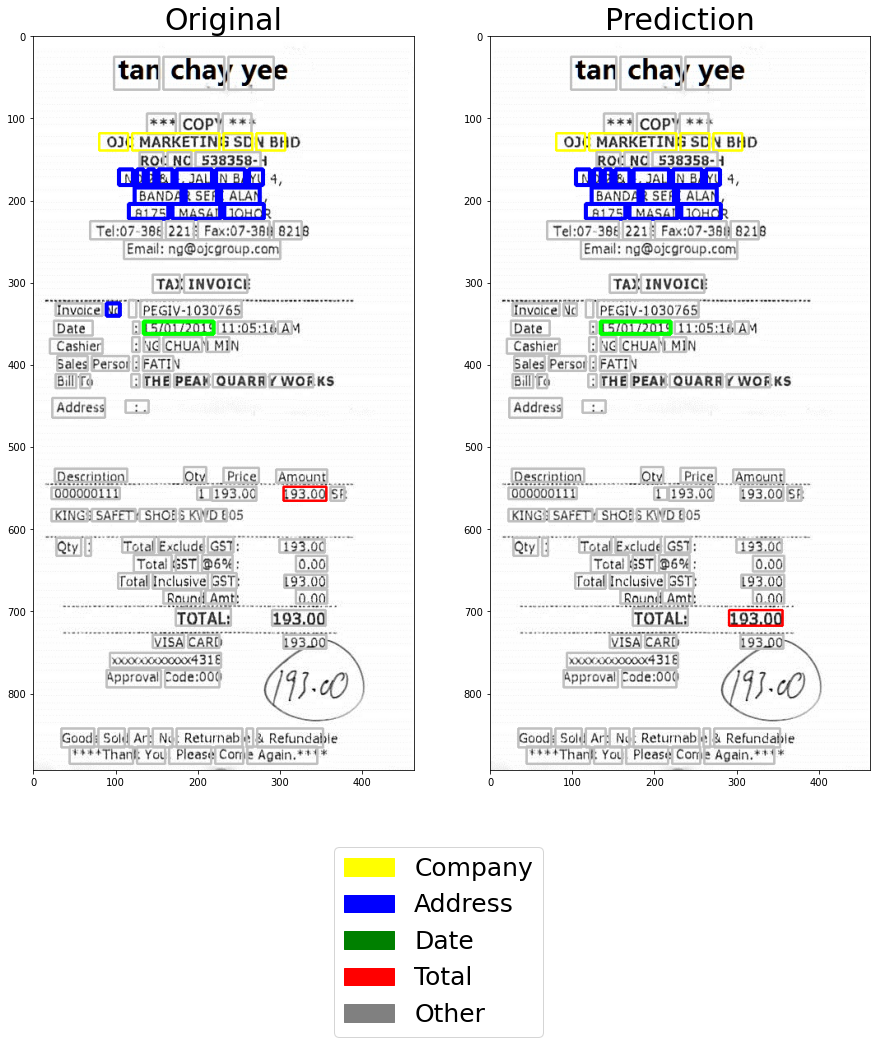

In [60]:
display_prediction(merged_groups[0], 'test')

Filename: X51005444046.jpg


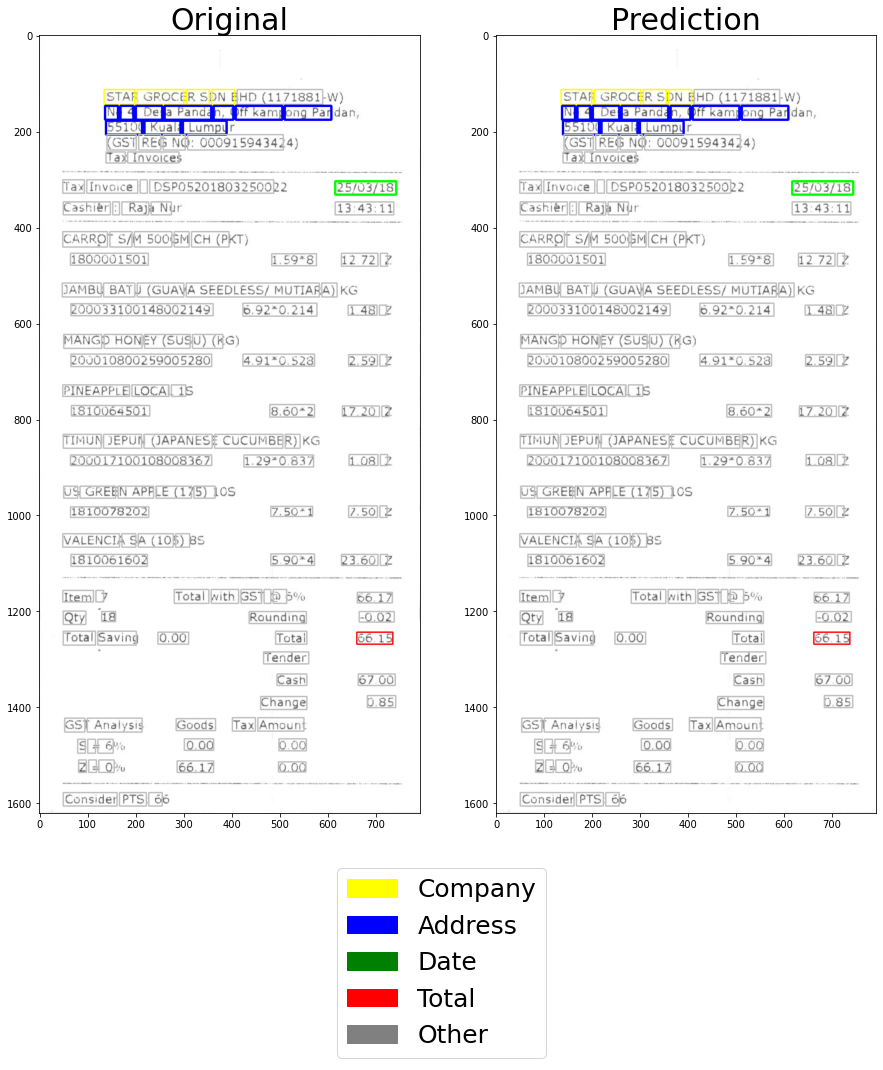

In [61]:
display_prediction(merged_groups[34], 'test')